In [1]:
#Dissipative preparation of tripartite singlet state in coupled arrays of cavities via quantum feedback control
#https://arxiv.org/pdf/1607.05413
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

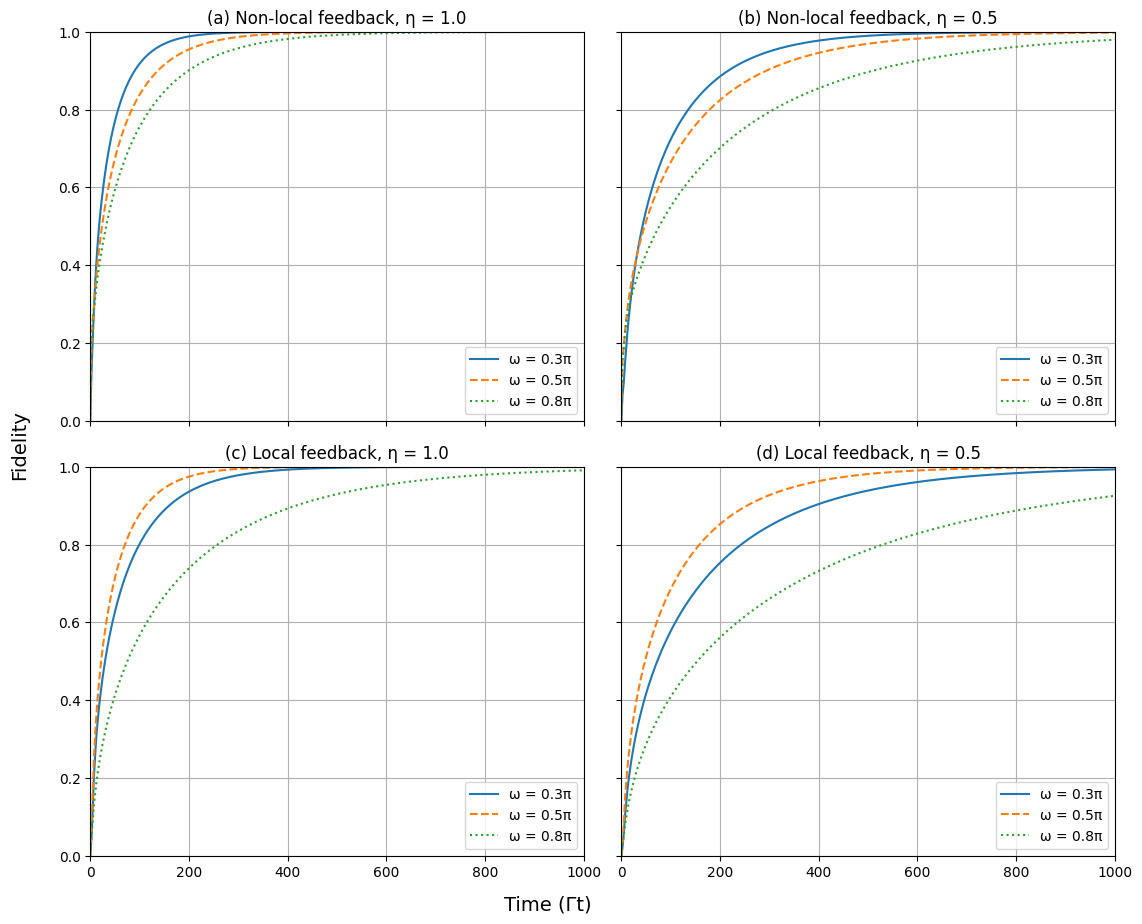

In [3]:
s0, s1, s2 = qt.basis(3, 0), qt.basis(3, 1), qt.basis(3, 2)
id_q = qt.qeye(3)
P10, P01 = s1 * s0.dag(), s0 * s1.dag()
P12, P21 = s1 * s2.dag(), s2 * s1.dag()

def op_on_atom(op, i):
    """辅助函数：将一个单原子算符 op 作用于第 i 个原子上 (i=0, 1, 2)"""
    ops = [id_q, id_q, id_q]
    ops[i] = op
    return qt.tensor(ops)
J1m = op_on_atom(P10, 0) + op_on_atom(P10, 1) + op_on_atom(P10, 2)
J2m = op_on_atom(P12, 0) + op_on_atom(P12, 1) + op_on_atom(P12, 2)
J1p, J2p = J1m.dag(), J2m.dag()

s3_unnormalized = (qt.tensor(s0, s1, s2) - qt.tensor(s1, s0, s2) - qt.tensor(s2, s1, s0) +
                   qt.tensor(s1, s2, s0) + qt.tensor(s2, s0, s1) - qt.tensor(s0, s2, s1))
S3 = s3_unnormalized.unit()

psi0 = qt.tensor(s1, s1, s1)
rho0 = psi0 * psi0.dag()

Gamma = 1.0 
Omega = 0.5 * Gamma 
tlist = np.linspace(0, 1000, 401) 
def run_simulation(feedback_type, eta, omega_list):
    """
    运行主方程模拟并返回保真度结果
    
    Args:
        feedback_type (str): 'nonlocal' 或 'local'
        eta (float): 探测效率 (0 to 1)
        omega_list (list): 要模拟的反馈频率 w 列表
        
    Returns:
        dict: 一个字典，键是 omega，值是保真度随时间变化的列表
    """
    results = {}

    H = Omega * (J1p + J1m) + Omega * (J2p + J2m)
    
    for w in omega_list:#function 17 
        c_ops = []
        
        if feedback_type == 'nonlocal':
            U_fb_op = -1j * w * (op_on_atom(P01 + P10, 0) + 2 * op_on_atom(P01 + P10, 1))
            U_fb = U_fb_op.expm()
            if eta > 0:
                c_ops.append(np.sqrt(eta * Gamma) * U_fb * J1m)
            if eta < 1:
                c_ops.append(np.sqrt((1 - eta) * Gamma) * J1m)

        elif feedback_type == 'local':
            if eta > 0:
                for i in range(3):
                    U_fb_i_op = -1j * w * op_on_atom(P01 + P10, i)
                    U_fb_i = U_fb_i_op.expm()
                    
                    c_ops.append(np.sqrt(eta * Gamma / 3.0) * U_fb_i * J1m)
            if eta < 1:
                c_ops.append(np.sqrt((1 - eta) * Gamma) * J1m)

        output = qt.mesolve(H, rho0, tlist, c_ops, e_ops=[])
        overlaps = qt.expect(S3 * S3.dag(), output.states)
        fidelities = np.sqrt(np.real(overlaps))
        results[w] = fidelities
        
    return results
omega_values = [0.3 * np.pi, 0.5 * np.pi, 0.8 * np.pi]
fids_nl_eta1 = run_simulation('nonlocal', 1.0, omega_values)
fids_nl_eta05 = run_simulation('nonlocal', 0.5, omega_values)
fids_loc_eta1 = run_simulation('local', 1.0, omega_values)
fids_loc_eta05 = run_simulation('local', 0.5, omega_values)

# --- 绘图 ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
linestyles = ['-', '--', ':']
def plot_panel(ax, data, title):
    for i, w in enumerate(omega_values):
        ax.plot(tlist, data[w], label=f'ω = {w/np.pi:.1f}π', color=colors[i], linestyle=linestyles[i])
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 1000)
plot_panel(axes[0, 0], fids_nl_eta1, '(a) Non-local feedback, η = 1.0')
plot_panel(axes[0, 1], fids_nl_eta05, '(b) Non-local feedback, η = 0.5')
plot_panel(axes[1, 0], fids_loc_eta1, '(c) Local feedback, η = 1.0')
plot_panel(axes[1, 1], fids_loc_eta05, '(d) Local feedback, η = 0.5')
fig.text(0.5, 0.04, 'Time (Γt)', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Fidelity', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.08, 0.05, 1, 0.95])
plt.savefig('paper2_grid.png', dpi=300)
plt.show()